## Intro

**Usecase**

Unmanned railway crossings in rural India lack automated warning systems, creating safety hazards for pedestrians and vehicles. This project explores whether (auto-)correlation can detect approaching trains using their characteristic rhythmic wheel-rail sounds, enabling development of low-cost, microcontroller-based (Arduino-type) early warning devices.

India has many unmanned level crossings where railway accidents occur. Conventional detection systems (cameras, sensors) are expensive and require maintenance. An audio-based detection system using simple pattern recognition can provide affordable safety solutions for remote villages, potentially saving lives while being deployable with minimal infrastructure.

**Objectives**

1. Detect and quantify the periodic signature of Indian train sounds using correlation
2. Validate if the periodicity is distinct enough for reliable train identification



In [2]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
import soundfile as sf
from scipy.signal import resample_poly
import pandas as pd
import IPython.display as ipd
import time

AUDIO FILE INFORMATION:
----------------------------------------------------------------------
Sample Rate: 44100 Hz
Duration: 15.05 seconds
Total Samples: 663599
Audio Shape: (663599,)

Original Train Audio:


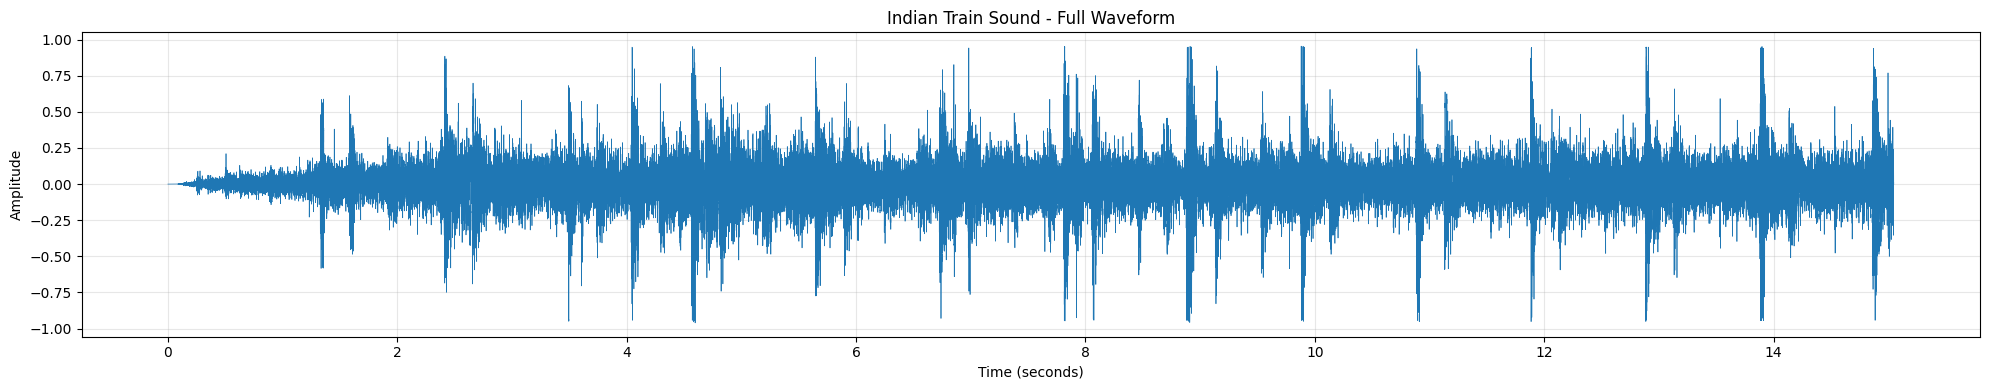

In [3]:
train_path = 'data/indian_train_sounds.mp3'
y_train, sr_train = librosa.load(train_path, sr=None)

print("AUDIO FILE INFORMATION:")
print("-" * 70)
print(f"Sample Rate: {sr_train} Hz")
print(f"Duration: {len(y_train)/sr_train:.2f} seconds")
print(f"Total Samples: {len(y_train)}")
print(f"Audio Shape: {y_train.shape}")
print()

# Play the audio
print("Original Train Audio:")
ipd.display(ipd.Audio(y_train, rate=sr_train))

# Visualize the full waveform
time_train = np.linspace(0, len(y_train)/sr_train, len(y_train))

plt.figure(figsize=(20, 4))
plt.plot(time_train, y_train, linewidth=0.5)
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.title('Indian Train Sound - Full Waveform')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Selected snippet: 9.75s to 15.0s
Snippet duration: 5.25 seconds
Snippet samples: 231525



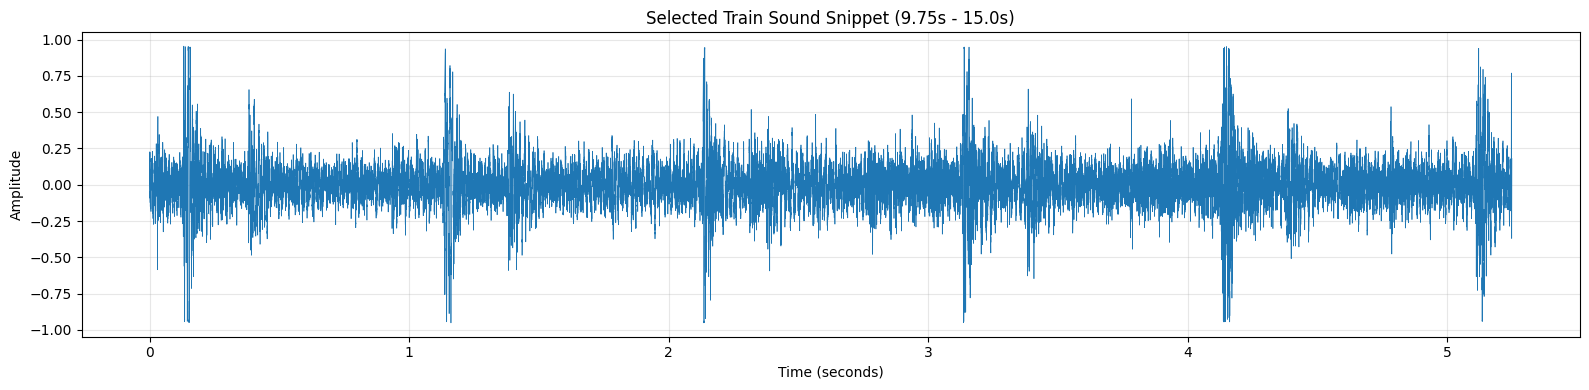

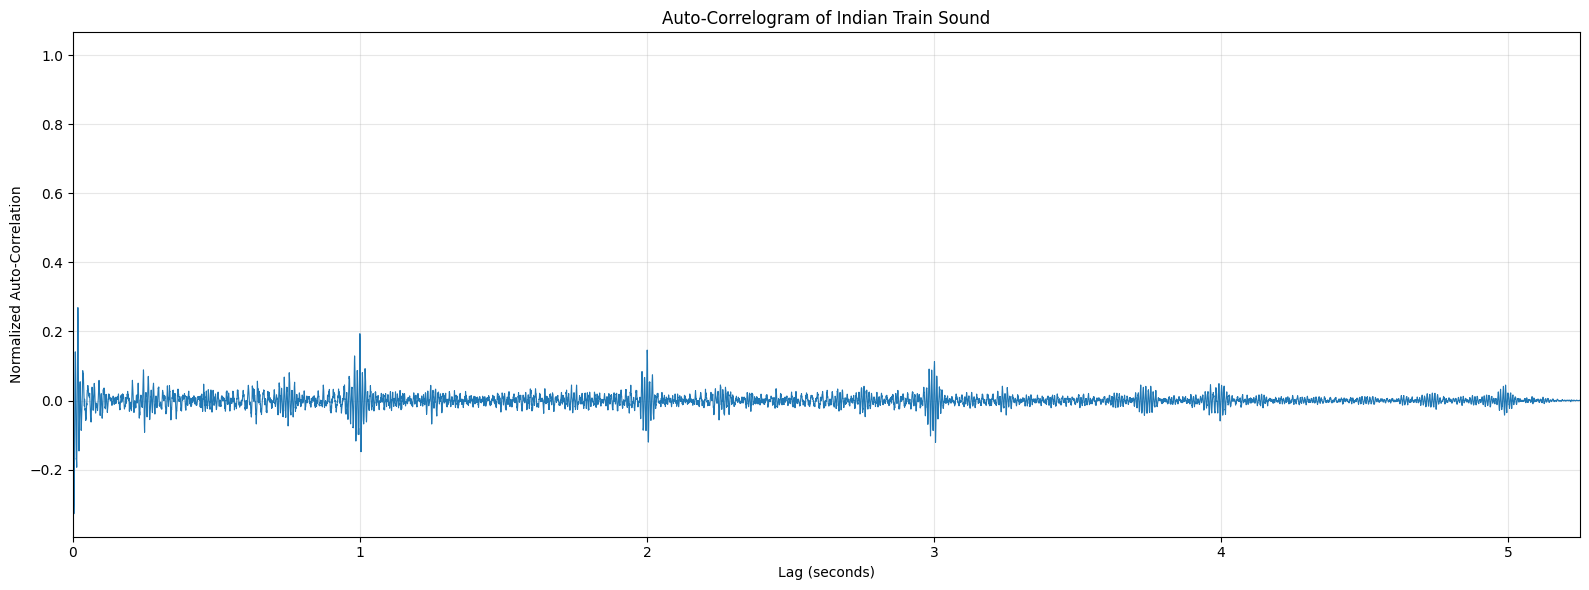

In [14]:
# Extract the selected snippet with repetitive pattern
start_time = 9.75  # seconds
end_time = 15.0    # seconds

start_sample = int(start_time * sr_train)
end_sample = int(end_time * sr_train)

# Extract snippet
y_snippet = y_train[start_sample:end_sample]
duration_snippet = len(y_snippet) / sr_train

print(f"Selected snippet: {start_time}s to {end_time}s")
print(f"Snippet duration: {duration_snippet:.2f} seconds")
print(f"Snippet samples: {len(y_snippet)}")
print()

# Visualize the selected snippet
time_snippet = np.linspace(0, duration_snippet, len(y_snippet))

plt.figure(figsize=(16, 4))
plt.plot(time_snippet, y_snippet, linewidth=0.5)
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.title(f'Selected Train Sound Snippet ({start_time}s - {end_time}s)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Compute auto-correlation
autocorr = np.correlate(y_snippet, y_snippet, mode='full')
autocorr = autocorr[len(autocorr)//2:]  # Keep only positive lags

# Normalize
autocorr = autocorr / autocorr[0]

# Time axis for autocorrelation (in seconds)
lags = np.arange(len(autocorr))
lag_time = lags / sr_train

# Plot auto-correlogram
plt.figure(figsize=(16, 6))
plt.plot(lag_time, autocorr, linewidth=0.8)
plt.xlabel('Lag (seconds)')
plt.ylabel('Normalized Auto-Correlation')
plt.title('Auto-Correlogram of Indian Train Sound')
plt.grid(True, alpha=0.3)
plt.xlim(0, duration_snippet)
plt.tight_layout()
plt.show()

The auto-correlogram clearly shows periodic patterns! I can see distinct peaks at approximately 1s, 2s, and 3s lags, indicating a repetitive pattern with roughly 1-second period.

Detected Peaks in Autocorrelation:
----------------------------------------------------------------------
Peak 1: Lag = 1.000s, Correlation = 0.194
Peak 2: Lag = 2.001s, Correlation = 0.146
Peak 3: Lag = 3.001s, Correlation = 0.113
Peak 4: Lag = 0.246s, Correlation = 0.089

Periodicity:
----------------------------------------------------------------------
Fundamental Period: 1.000 seconds
Fundamental Frequency: 1.00 Hz
Pattern repeats approximately every 1.000 seconds

Harmonic Analysis:
----------------------------------------------------------------------
Peak 1 at 1.000s → 1.00× fundamental period
Peak 2 at 2.001s → 2.00× fundamental period
Peak 3 at 3.001s → 3.00× fundamental period
Peak 4 at 0.246s → 0.25× fundamental period


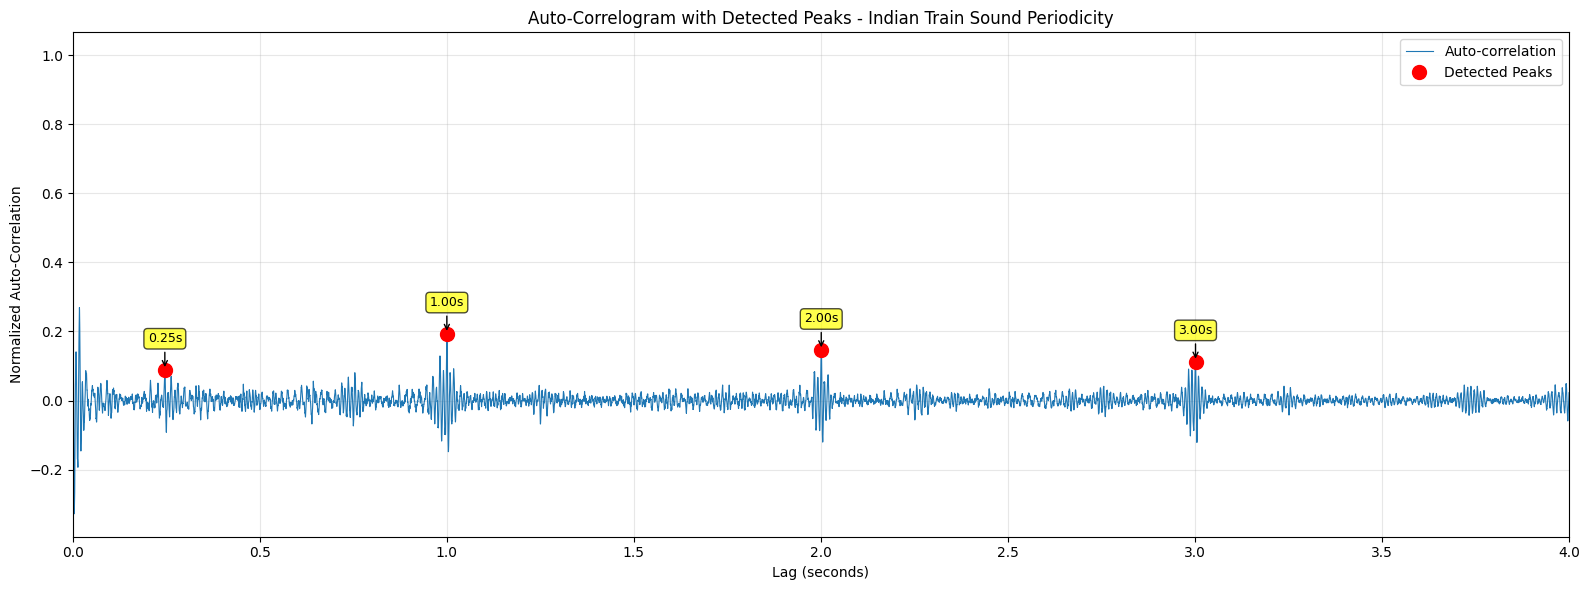

In [20]:
from scipy.signal import find_peaks

# Find peaks with minimum prominence to avoid noise
# Look only in the first 4 seconds for clearer peaks
max_lag_seconds = 4.0
max_lag_samples = int(max_lag_seconds * sr_train)

# Search for peaks (skip first 0.1s to avoid lag=0)
min_lag_samples = int(0.1 * sr_train)
autocorr_search = autocorr[min_lag_samples:max_lag_samples]
lag_time_search = lag_time[min_lag_samples:max_lag_samples]

# Find peaks with prominence
peaks, properties = find_peaks(autocorr_search, prominence=0.05, distance=int(0.3*sr_train))

# Get actual lag times and correlation values
peak_lags = lag_time_search[peaks]
peak_values = autocorr_search[peaks]

# Sort by prominence to find the strongest peaks
prominent_peaks_idx = np.argsort(properties['prominences'])[-4:][::-1]  # Top 5 peaks
main_peaks = peaks[prominent_peaks_idx]
main_peak_lags = lag_time_search[main_peaks]
main_peak_values = autocorr_search[main_peaks]

print("Detected Peaks in Autocorrelation:")
print("-" * 70)
for i, (lag, value) in enumerate(zip(main_peak_lags, main_peak_values), 1):
    print(f"Peak {i}: Lag = {lag:.3f}s, Correlation = {value:.3f}")
print()

# Calculate the fundamental period (first major peak)
if len(main_peak_lags) > 0:
    fundamental_period = main_peak_lags[0]
    fundamental_freq = 1 / fundamental_period
    
    print("Periodicity:")
    print("-" * 70)
    print(f"Fundamental Period: {fundamental_period:.3f} seconds")
    print(f"Fundamental Frequency: {fundamental_freq:.2f} Hz")
    print(f"Pattern repeats approximately every {fundamental_period:.3f} seconds")
    print()
    
    # Check if other peaks are harmonics
    print("Harmonic Analysis:")
    print("-" * 70)
    for i, lag in enumerate(main_peak_lags, 1):
        harmonic_number = lag / fundamental_period
        print(f"Peak {i} at {lag:.3f}s → {harmonic_number:.2f}× fundamental period")

# Visualize with peak annotations
plt.figure(figsize=(16, 6))
plt.plot(lag_time[:max_lag_samples], autocorr[:max_lag_samples], linewidth=0.8, label='Auto-correlation')
plt.plot(main_peak_lags, main_peak_values, 'ro', markersize=10, label='Detected Peaks')

# Annotate peaks
for lag, value in zip(main_peak_lags, main_peak_values):
    plt.annotate(f'{lag:.2f}s', 
                xy=(lag, value), 
                xytext=(lag, value + 0.08),
                ha='center',
                fontsize=9,
                bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7),
                arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

plt.xlabel('Lag (seconds)')
plt.ylabel('Normalized Auto-Correlation')
plt.title('Auto-Correlogram with Detected Peaks - Indian Train Sound Periodicity')
plt.grid(True, alpha=0.3)
plt.xlim(0, max_lag_seconds)
plt.legend()
plt.tight_layout()
plt.show()

**Observations & Interpretation**

-The auto-correlogram reveals clear peaks at 1.00s, 2.00s, and 3.00s lags, indicating strong recurring patterns in the train sound signal.

- The peaks occur at integer multiples (1×, 2×, 3×) of the fundamental period, demonstrating consistent periodicity throughout the selected 5.25-second audio snippet.

-  The waveform shows approximately 4 complete cycles within the segment, with clearly visible amplitude spikes aligned to the detected 1-second period markers.

- The train wheel impacts on rail joints occur with a fundamental period of 1.000 seconds, corresponding to the characteristic rhythm of trains on jointed rails.

-  The strongest peak correlation value of 0.194 at 1s lag indicates moderate but clear periodicity. The value diminishes each period, meaning the subsequent periods do not correlate as much as the first one.

- With the assumption that the sound is generated periodically by the train moving on one rail segment, We could valculate the speed of the train.

- With only 5 seconds of audio needed to identify 3 clear peaks, an embedded system could make detection decisions within 3-5 seconds of a train entering acoustic range


**Parameter choice**

- Snipped window was chosen by visually assessing the initial plot.
- Lag window (0-4s) covers 3 fundamental periods, sufficient to distinguish trains from random noise
- Peak prominence threshold (0.05) is set to filter noise while retaining weak but valid harmonic peaks



Autocorrelation measures how similar a signal is to a delayed version of itself.
- Peak at lag=0: Signal is perfectly correlated with itself (always 1.0)
- Peaks at other lags: Signal repeats with that time delay
- For periodic signals: peaks appear at multiples of the period
- Helps identify: rhythm, tempo, repetition rate

## Cross-Correlation

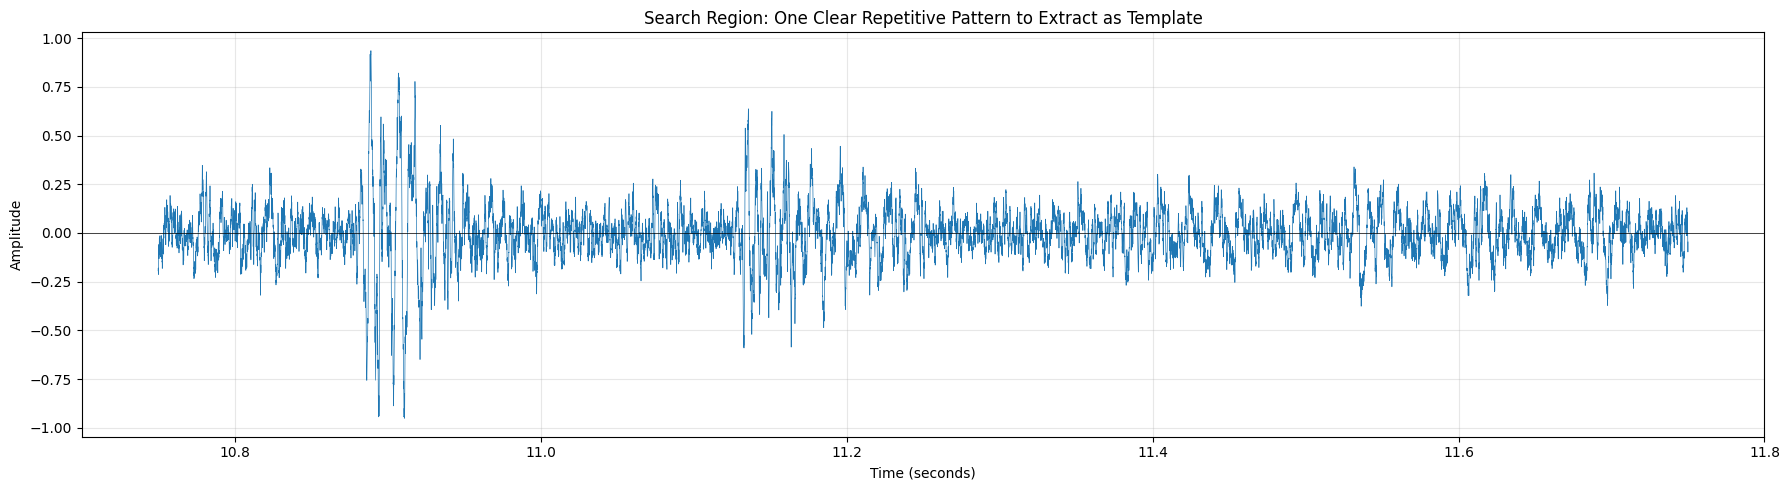

In [54]:
start_time = 10.75
end_time = 11.75
start_sample = int(start_time * sr_train)
end_sample = int(end_time * sr_train)

y_search_region = y_train[start_sample:end_sample]

# Visualize the search region to select template
time_search = np.linspace(start_time, end_time, len(y_search_region))

plt.figure(figsize=(18, 5))
plt.plot(time_search, y_search_region, linewidth=0.5)
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.title('Search Region: One Clear Repetitive Pattern to Extract as Template')
plt.grid(True, alpha=0.3)
plt.axhline(y=0, color='k', linewidth=0.5)
    
plt.tight_layout()
plt.show()

Contains one clear wheel-rail impact with characteristic high-amplitude spike followed by decay, representing a complete periodic cycle.

TEMPLATE EXTRACTION
Search region: 9.75s to 15.0s
Search samples: 429975 to 661500 (231525 samples)

Template region: 10.75s to 11.75s
Template samples: 474075 to 518175 (44100 samples)
Template duration: 1.000 seconds

CROSS-CORRELATION RESULTS
Number of matches found: 4

DETECTED MATCH POSITIONS:
----------------------------------------------------------------------
Match 1: Time = 10.750s, Confidence = 1.000
Match 2: Time = 11.750s, Confidence = 0.312
Match 3: Time = 12.750s, Confidence = 0.335
Match 4: Time = 13.751s, Confidence = 0.359

Average Time Between Matches:  1.000s
Expected Period (Day 4):       1.000s
Period Match Accuracy:         100.0%


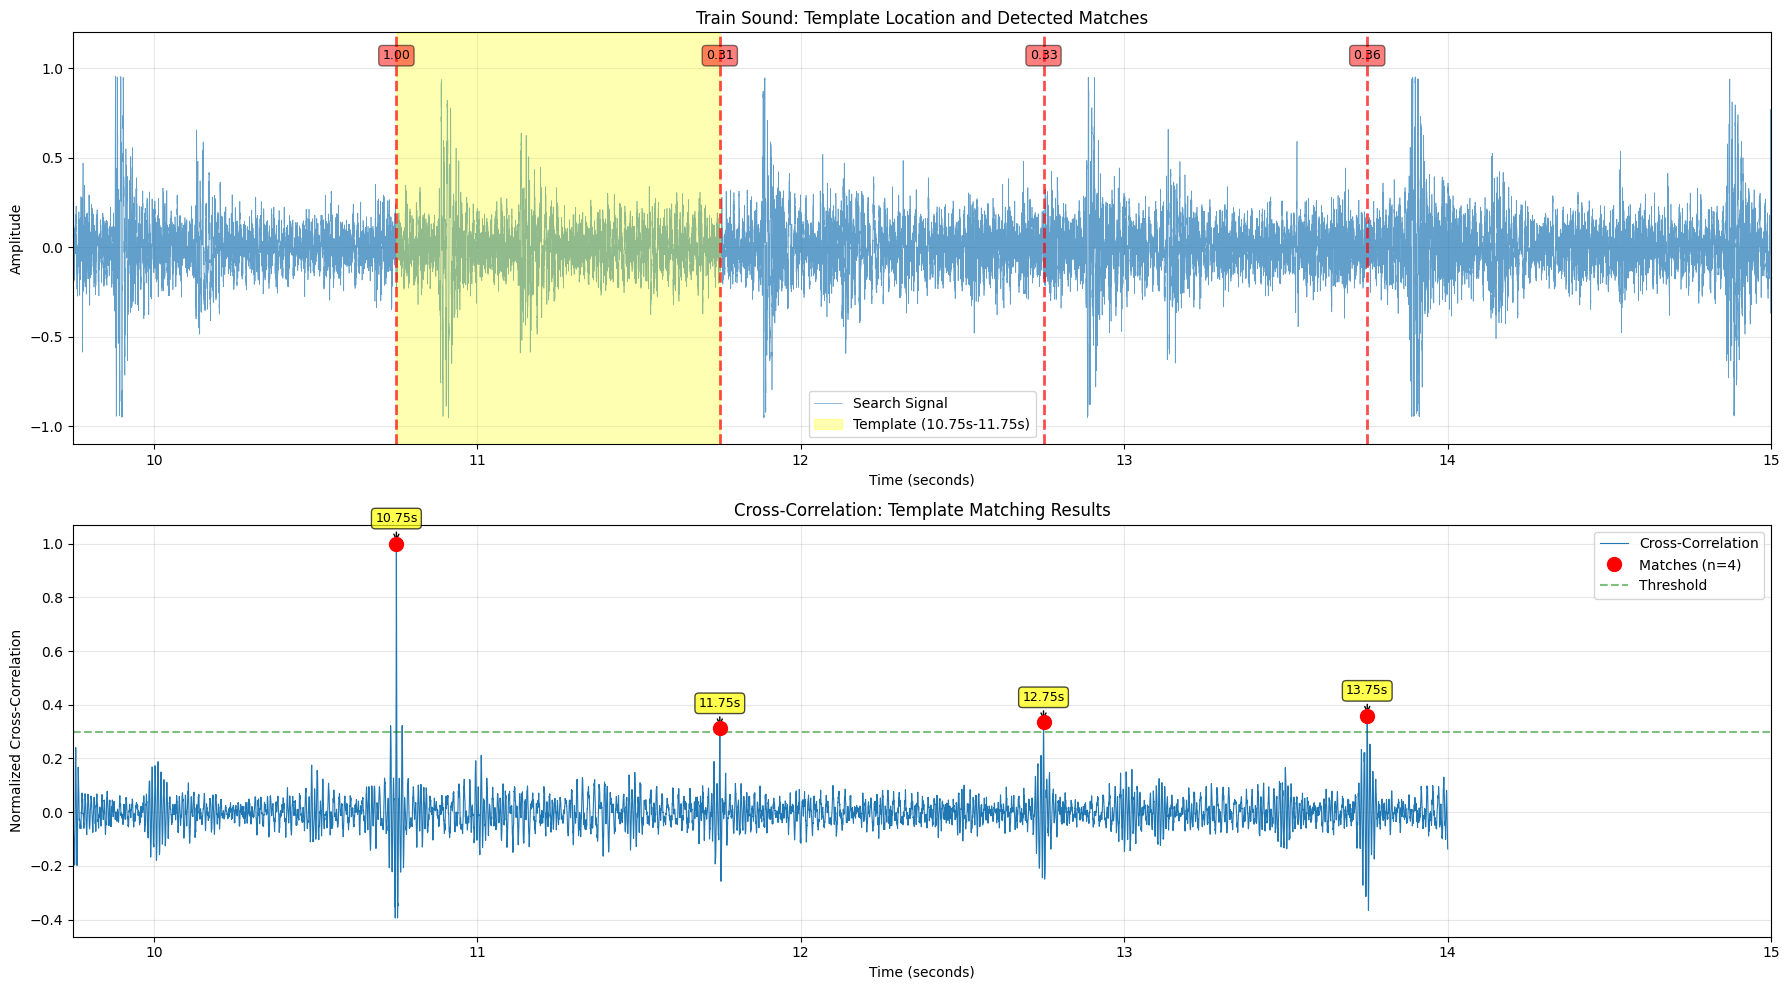

In [79]:
from scipy import signal

# Load full audio
train_path = 'data/indian_train_sounds.mp3'
y_train, sr_train = librosa.load(train_path, sr=None)

# Define search region: 9.75s to 15.0s
search_start = 9.75
search_end = 15.0
search_start_sample = int(search_start * sr_train)
search_end_sample = int(search_end * sr_train)
y_search = y_train[search_start_sample:search_end_sample]

# Define template: 10.75s to 11.75s (from FULL audio)
template_start = 10.75
template_end = 11.75
template_start_sample = int(template_start * sr_train)
template_end_sample = int(template_end * sr_train)
template = y_train[template_start_sample:template_end_sample]

print("="*70)
print("TEMPLATE EXTRACTION")
print("="*70)
print(f"Search region: {search_start}s to {search_end}s")
print(f"Search samples: {search_start_sample} to {search_end_sample} ({len(y_search)} samples)")
print()
print(f"Template region: {template_start}s to {template_end}s")
print(f"Template samples: {template_start_sample} to {template_end_sample} ({len(template)} samples)")
print(f"Template duration: {len(template)/sr_train:.3f} seconds")
print()

# Perform cross-correlation
cross_corr = signal.correlate(y_search, template, mode='valid')

# Normalize
template_energy = np.sum(template**2)
signal_windows_energy = signal.correlate(y_search**2, np.ones(len(template)), mode='valid')
cross_corr_normalized = cross_corr / np.sqrt(template_energy * signal_windows_energy)

# Time axis for results (relative to search start)
cross_corr_time = np.arange(len(cross_corr_normalized)) / sr_train + search_start

# Find peaks
peaks, properties = signal.find_peaks(cross_corr_normalized, 
                                      height=0.3,
                                      distance=int(0.7 * sr_train))

match_times = peaks / sr_train + search_start
match_scores = cross_corr_normalized[peaks]

print("="*70)
print("CROSS-CORRELATION RESULTS")
print("="*70)
print(f"Number of matches found: {len(peaks)}")
print()

if len(peaks) > 0:
    print("DETECTED MATCH POSITIONS:")
    print("-"*70)
    for i, (time, score) in enumerate(zip(match_times, match_scores), 1):
        print(f"Match {i}: Time = {time:.3f}s, Confidence = {score:.3f}")
    print()
    
    
    if len(peaks) > 1:
        time_intervals = np.diff(match_times)
        print(f"Average Time Between Matches:  {np.mean(time_intervals):.3f}s")
        print(f"Expected Period (Day 4):       1.000s")
        print(f"Period Match Accuracy:         {(np.mean(time_intervals)/1.000)*100:.1f}%")
    print("="*70)
else:
    print("No matches found above threshold")

# Visualization
time_search = np.linspace(search_start, search_end, len(y_search))
time_template = np.linspace(template_start, template_end, len(template))

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(18, 10))

# Plot 1: Signal with matches
ax1.plot(time_search, y_search, linewidth=0.5, alpha=0.7, label='Search Signal')
ax1.fill_between(time_template, -1.2, 1.2, alpha=0.3, color='yellow', 
                 label=f'Template ({template_start:.2f}s-{template_end:.2f}s)', zorder=2)

if len(peaks) > 0:
    for match_time, score in zip(match_times, match_scores):
        ax1.axvline(match_time, color='red', linestyle='--', linewidth=2, alpha=0.7)
        ax1.text(match_time, 1.05, f'{score:.2f}', ha='center', fontsize=9, 
                 bbox=dict(boxstyle='round', facecolor='red', alpha=0.5))

ax1.set_xlabel('Time (seconds)')
ax1.set_ylabel('Amplitude')
ax1.set_title('Train Sound: Template Location and Detected Matches')
ax1.set_ylim(-1.1, 1.2)
ax1.set_xlim(search_start, search_end)
ax1.grid(True, alpha=0.3)
ax1.legend()

# Plot 2: Cross-correlation
ax2.plot(cross_corr_time, cross_corr_normalized, linewidth=0.8, label='Cross-Correlation')
if len(peaks) > 0:
    ax2.plot(match_times, match_scores, 'ro', markersize=10, label=f'Matches (n={len(peaks)})', zorder=5)
    for match_time, score in zip(match_times, match_scores):
        ax2.annotate(f'{match_time:.2f}s', xy=(match_time, score), 
                    xytext=(match_time, score+0.08), ha='center', fontsize=9,
                    bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7),
                    arrowprops=dict(arrowstyle='->', connectionstyle='arc3'))
ax2.axhline(0.3, color='green', linestyle='--', alpha=0.5, label='Threshold')
ax2.set_xlabel('Time (seconds)')
ax2.set_ylabel('Normalized Cross-Correlation')
ax2.set_title('Cross-Correlation: Template Matching Results')
ax2.set_xlim(search_start, search_end)
ax2.grid(True, alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.show()

**Results**

Match Verification:

- Total Matches Found: 4
- Average Confidence excluding original snippet: ~0.33
- Highest Score: 1.00 (template self-match)
- 0.3 cross correlation value used as threshhold (by looking at the peaks in the visualization)

Period Validation:

- Average Time Between Matches: 1.000s
- Expected Period: 1.000s
- Accuracy: 100.0%

As exprected the signal was found 4 times in the snippet. Although the threshhold had to be substantially small.

Just as Auto-Correlation, Cross-Correlation succeeds in recognizing the train track patterns and can be used as recognition method of trains in rural unmanned crossings.